# Addressing Outliers, Modeling, and Profiling

**Import Libraries**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as pyoff 
import plotly.express as px

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

**Load Cleaned Data**

In [2]:
cc = pd.read_csv('data/clean_dataset.csv')

In [3]:
cc.head(10)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   
5  C10006  1809.828751           1.000000    1333.28              0.00   
6  C10007   627.260806           1.000000    7091.01           6402.63   
7  C10008  1823.652743           1.000000     436.20              0.00   
8  C10009  1014.926473           1.000000     861.49            661.49   
9  C10010   152.225975           0.545455    1281.60           1281.60   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                   95.40      0.000000             0.166667   
1                    0.00   6442.945483             0.000000   
2                    0.00      0.000000             1.000000   
3                    0.00    205.788017             0.083333   
4                    0.00      0.000000             0.083333   
5                 1333.28      0.000000             0.666667   
6                  688.38      0.000000             1.000000   
7                  436.20      0.000000             1.000000   
8                  200.00      0.000000             0.333333   
9                    0.00      0.000000             0.166667   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   
5                    0.000000                          0.583333   
6                    1.000000                          1.000000   
7                    0.000000                          1.000000   
8                    0.083333                          0.250000   
9                    0.166667                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   
5                0.000000                 0              8        1800.0   
6                0.000000                 0             64       13500.0   
7                0.000000                 0             12        2300.0   
8                0.000000                 0              5        7000.0   
9                0.000000                 0              3       11000.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cc_utilization  
0   201.802084        139.509787          0.000000      12        0.040901  
1  4103.032597       1072.340217          0.222222      12        0.457495  
2   622.066742        627.284787          0.000000      12        0.332687  
3     0.000000          0.000000          0.000000      12        0.222223  
4   678.334763        244.791237          0.000000      12        0.681429  
5  1400.057770       2407.246035          0.000000      12        1.005460  
6  6354.314328        198.065894          1.000000      12        0.046464  
7   679.065082        532.033990          0.000000      12        0.792892  
8   688.278568        311.963409          0.000000      12        0.144989  
9  1164.770591        100.302262          0.000000      12        0.013839

In [4]:
cc.set_index('CUST_ID', inplace=True)

# Interquartile Range
One way of detecting and filtering outliers is to use the interquartile range (IQR). The upper limit for our observations is `Q3 + 1.5 * IQR` and the lower bound is `Q1 - 1.5 * IQR`, where,
* Q1 = 25th percentile 
* Q2 = 75th percentile
* IQR = Q3 - Q1

In other words, the values more extreme than the whiskers of the boxplots that we plotted during EDA

In [5]:
df_iqr = cc.copy()

In [6]:
'''
function calculates the upper bound and lower
returns the index of observations that are outliers
'''

def outliers(df, feature):
    Q3 = df[feature].quantile(0.75)
    Q1 = df[feature].quantile(0.25)
    IQR = Q3 - Q1
    
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    
    ls = df.index[(df[feature] < lower_bound) | (df[feature] > upper_bound) ]

    return ls

In [7]:
# for loop to run function on multiple features
index_list =[]
for feature in df_iqr.columns:
    index_list.extend(outliers(df_iqr, feature)) # extend: elements of iterable are added to end of list

In [8]:
# function to remove the outliers 
def remove(df, ls):
    ls = sorted(set(ls)) # remove duplicate indexes
    df = df.drop(ls) # drop index of outliers from dataframe
    return df

In [9]:
df_cleaned = remove(df_iqr, index_list)

In [10]:
df_cleaned.shape[0] / cc.shape[0]

0.3337430167597765

Wow, only a third of our original data was retained. Removing outliers using IQR removes too many customers. We will try a second technique below.

# Binning
In order to not lose too much data, we will use binning, also known as discretization. Binning will allow us to deal with the outliers without actually removing customers. Through putting customer credit card data into bins, we can smooth the distributions of the variables, and it will also help with k-means clustering, which relies on distance and is affected by outliers.

**Limitations:**
Binning is quite arbitrary--the determination of bin size and the number of bins is often subjectively chosen. Ideally, we would have a domain expert with business acumen to help choose bin sizes. As we do not have this luxury, we will continue based on the range of values for each variable and by analyzing the histograms/boxplots.

In [11]:
# drop Tenure and PRC_FULL_PAYMENT
cc = cc.drop(['TENURE','PRC_FULL_PAYMENT'], axis=1)

We drop these columns because when we did EDA, they are mainly all one value, and thus do not offer much information to help differentiate clusters.

In [12]:
df = cc.copy()

In [13]:
df.shape

(8950, 16)

**Features with Ranges From 0 to 1**

For the most part credit card utilization and the columns measuring frequency range between 0 and 1 with some observations going above 1. We will group the columns in the cell below into 5 bins of 0.2 increments with the last bin including the max value

In [14]:
features_set1 = ['cc_utilization'] 
features_set1.extend(df.filter(like='FREQUENCY').columns)

for feature in features_set1:
    new_column = feature+'_BIN'
    
    maxrange =np.ceil(max(df[feature]))
    labels = np.arange(1, 6)
    bins = np.arange(0, 1, 0.2)
    bins = np.append(bins, maxrange)
    df[new_column] = pd.cut(df[feature], bins=bins, labels=labels, include_lowest=True)

**# of Transactions:**

Most of the observations are between 0 and 30 so we will increment initially by 5 and then gradually increase the binning increments.

In [15]:
features_set2 = ['CASH_ADVANCE_TRX', 'PURCHASES_TRX']

for feature in features_set2:
    new_column = feature+'_BIN'
    
    maxrange = np.ceil(max(df[feature]))
    bins = [0, 5, 15, 30, 60, 100, maxrange]
    labels = np.arange(1, 7)
    df[new_column] = pd.cut(df[feature], bins=bins, labels=labels, include_lowest=True)

**The Rest of the Variables**: 

The range of values for the last set of features are more spread out than the other feature sets. We will increase the size of the bins in gradually wider increments.

In [16]:
features_set3 = list(set(cc.columns) - set(features_set1) - set(features_set2))
features_set3

['CASH_ADVANCE',
 'PAYMENTS',
 'CREDIT_LIMIT',
 'BALANCE',
 'PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'ONEOFF_PURCHASES',
 'MINIMUM_PAYMENTS']

In [17]:
for feature in features_set3:
    new_column = feature+'_BIN'
    
    maxrange = np.ceil(max(df[feature]))
    bins = [0, 500, 1000, 2000, 4000, 6000, 10000, maxrange]
    labels = np.arange(1,8)
    df[new_column] = pd.cut(df[feature], bins=bins, labels=labels, include_lowest=True)

**Update the dataframe with the new _BIN columns**

In [18]:
list_bins = list(set(df.columns) - set(cc)) 

In [19]:
cc = df[list_bins]
print(cc.shape)
cc.head()

(8950, 16)


PURCHASES_FREQUENCY_BIN CASH_ADVANCE_BIN cc_utilization_BIN  \
CUST_ID                                                               
C10001                        1                1                  1   
C10002                        1                6                  3   
C10003                        5                1                  2   
C10004                        1                1                  2   
C10005                        1                1                  4   

        BALANCE_BIN BALANCE_FREQUENCY_BIN ONEOFF_PURCHASES_FREQUENCY_BIN  \
CUST_ID                                                                    
C10001            1                     5                              1   
C10002            4                     5                              1   
C10003            4                     5                              5   
C10004            3                     4                              1   
C10005            2                     5                              1   

        PAYMENTS_BIN PURCHASES_TRX_BIN CASH_ADVANCE_TRX_BIN  \
CUST_ID                                                       
C10001             1                 1                    1   
C10002             5                 1                    1   
C10003             2                 2                    1   
C10004             1                 1                    1   
C10005             2                 1                    1   

        CASH_ADVANCE_FREQUENCY_BIN MINIMUM_PAYMENTS_BIN  \
CUST_ID                                                   
C10001                           1                    1   
C10002                           2                    3   
C10003                           1                    2   
C10004                           1                    1   
C10005                           1                    1   

        PURCHASES_INSTALLMENTS_FREQUENCY_BIN PURCHASES_BIN  \
CUST_ID                                                      
C10001                                     1             1   
C10002                                     1             1   
C10003                                     1             2   
C10004                                     1             3   
C10005                                     1             1   

        INSTALLMENTS_PURCHASES_BIN CREDIT_LIMIT_BIN ONEOFF_PURCHASES_BIN  
CUST_ID                                                                   
C10001                           1                2                    1  
C10002                           1                6                    1  
C10003                           1                6                    2  
C10004                           1                6                    3  
C10005                           1                3                    1

## Scaling

In [20]:
scale = StandardScaler()
X = np.array(cc)
X = scale.fit_transform(X)

## KMEANs

In [21]:
K_range = range(2, 20)
wcss = []

for K in K_range:
    model = KMeans(n_clusters = K, random_state=42)
    model.fit(X)
    wcss.append(model.inertia_)

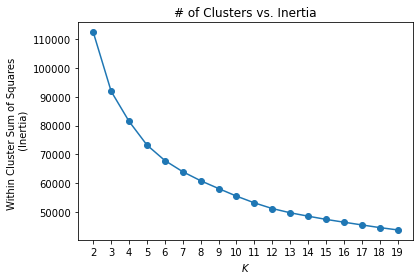

In [22]:
plt.plot(K_range, wcss, marker='o')
plt.xticks(K_range)
plt.title("# of Clusters vs. Inertia")
plt.xlabel('$K$')
plt.ylabel('Within Cluster Sum of Squares \n (Inertia)')
plt.show()

By using bins, the elbow plot has a steeper drop and lower inertia. A good value for K might be at 5 or 6

**Silhouette Method**

The silhouette method uses what is know as a silhouette coefficient to determine the best number of clusters. The silhouette coefficient has values ranging from 0 to 1

For n_clusters = 2 The average silhouette_score is : 0.24700418464589882
For n_clusters = 3 The average silhouette_score is : 0.23556384534757085
For n_clusters = 4 The average silhouette_score is : 0.1943598412656122
For n_clusters = 5 The average silhouette_score is : 0.21013405107366673
For n_clusters = 6 The average silhouette_score is : 0.2176657921700374
For n_clusters = 7 The average silhouette_score is : 0.22314926190991854
For n_clusters = 8 The average silhouette_score is : 0.21351277533219032
For n_clusters = 9 The average silhouette_score is : 0.20384072457397018
For n_clusters = 10 The average silhouette_score is : 0.1881068091305008
For n_clusters = 11 The average silhouette_score is : 0.19287817444581337
For n_clusters = 12 The average silhouette_score is : 0.19525512845902324
For n_clusters = 13 The average silhouette_score is : 0.19296070417171063
For n_clusters = 14 The average silhouette_score is : 0.19029793319492175
For n_clusters = 15 The average silhouette_score 

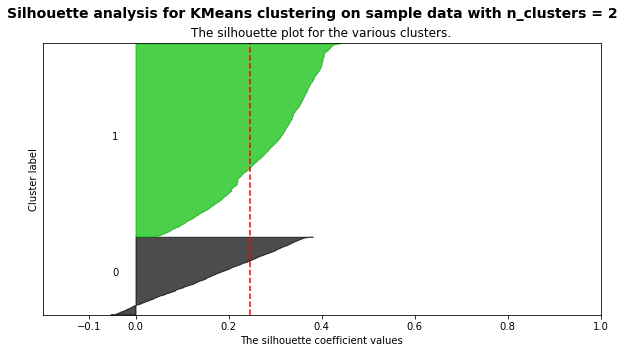

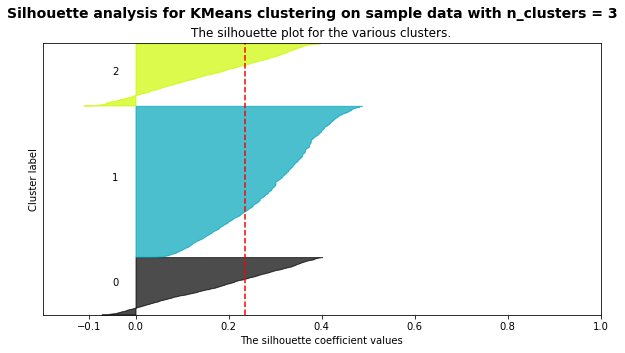

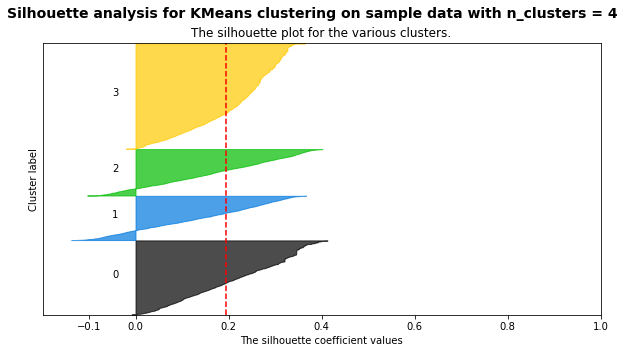

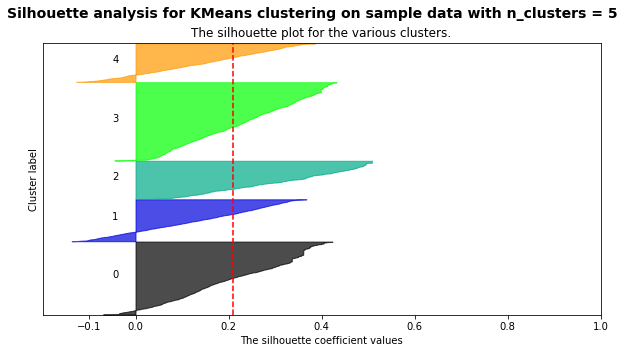

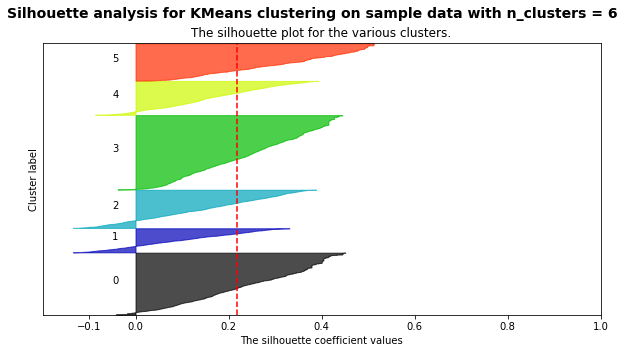

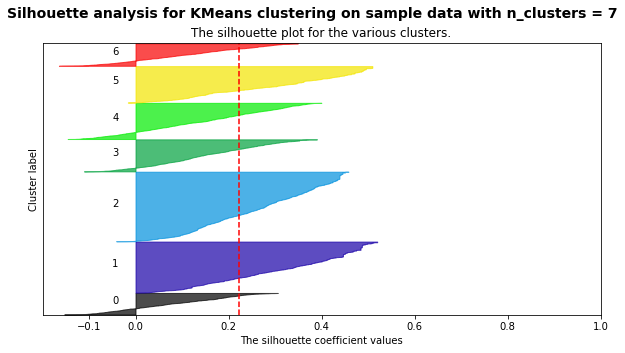

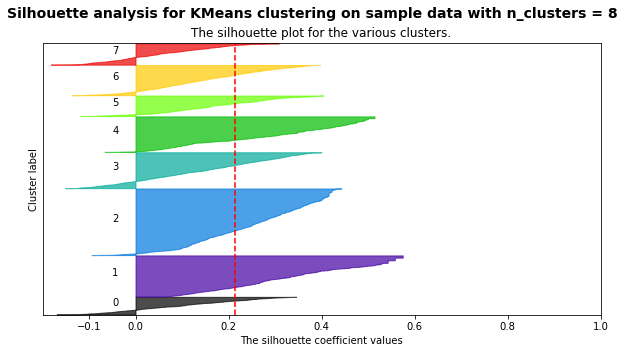

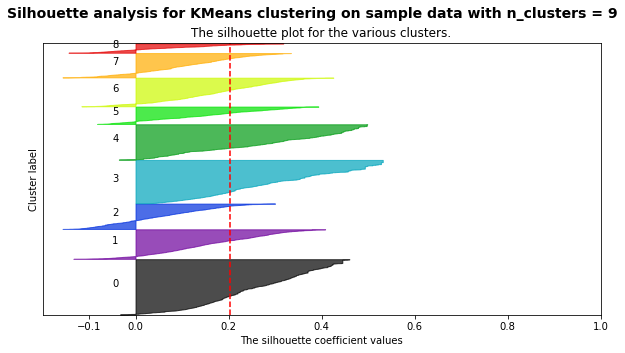

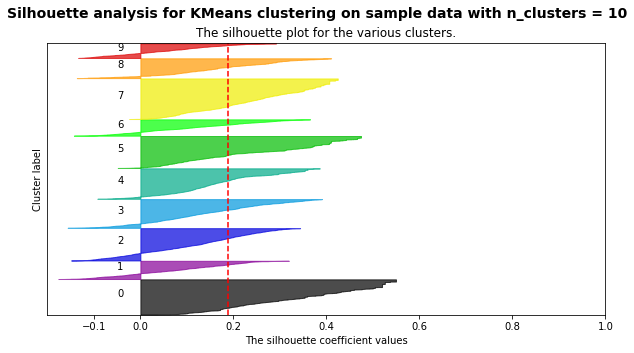

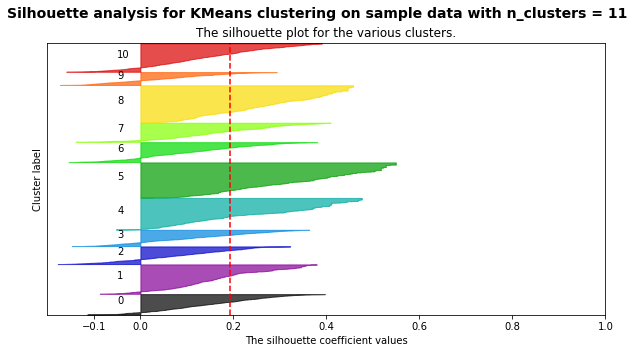

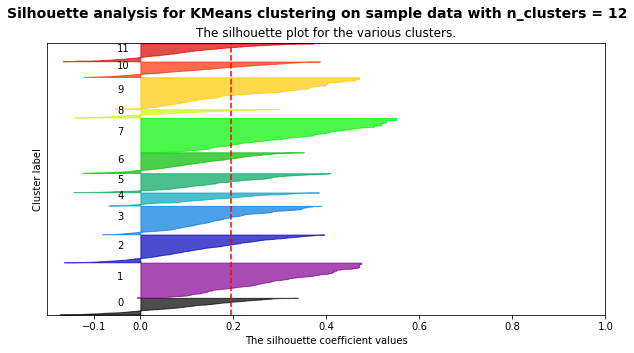

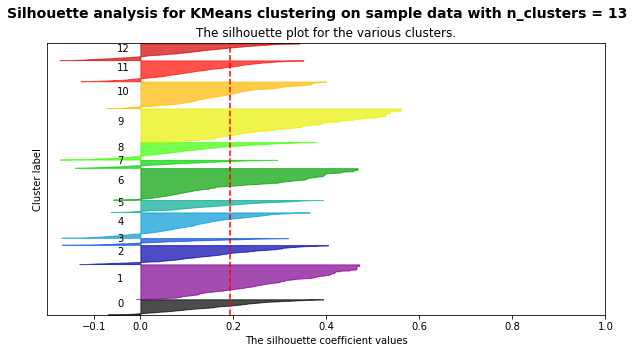

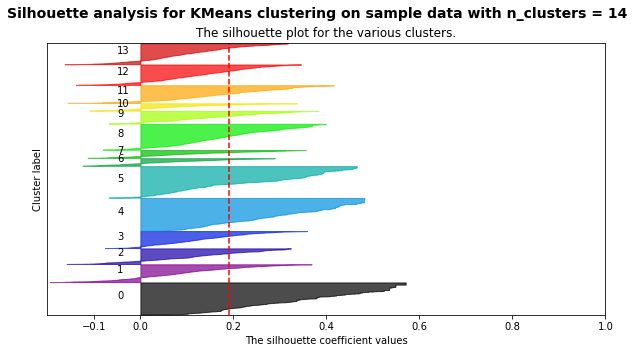

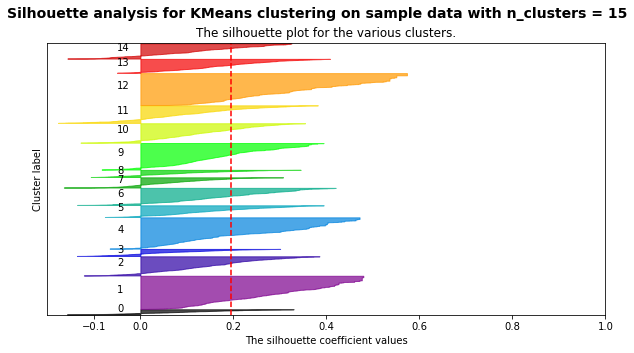

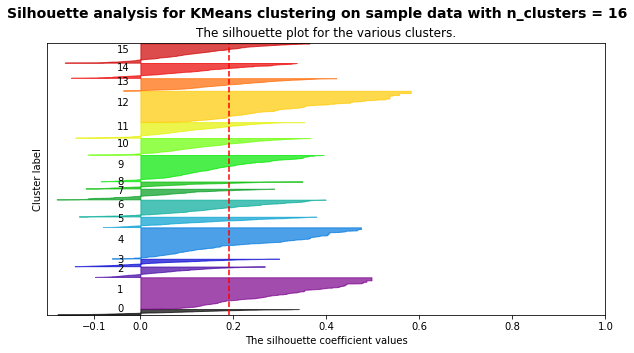

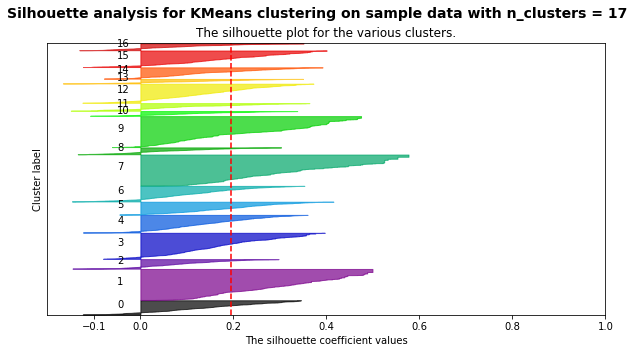

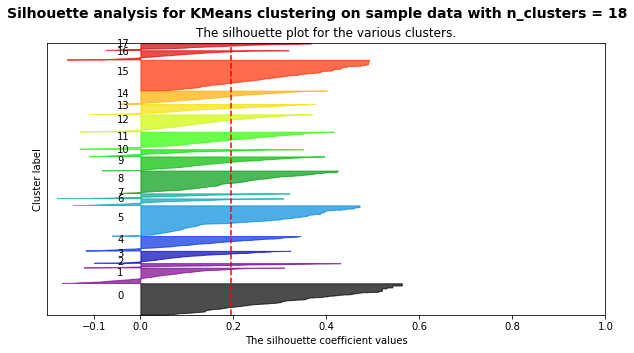

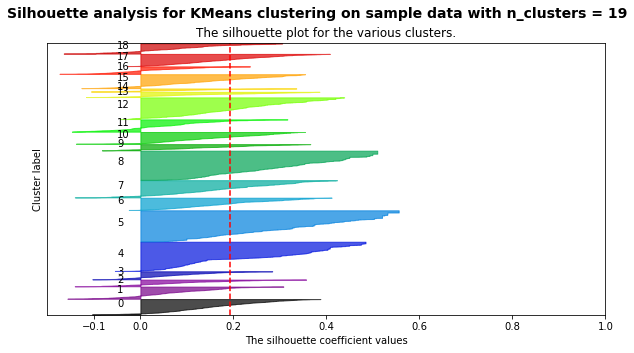

In [23]:
'''
Sci-kit learn offers a handy function to the retrieve the silhoutte score. 
The block of code is adapted from a sci-kit learn article on selecting the number of clusters
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
'''
avg_silhouette_scores = []

for n_clusters in K_range:
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(10, 5)
    
     # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1)* 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    avg_silhouette_scores.append(silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

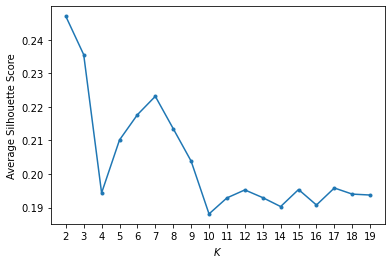

In [24]:
plt.plot(K_range, avg_silhouette_scores, marker='.')
plt.xlabel('$K$')
plt.ylabel('Average Silhouette Score')
plt.xticks(K_range)
plt.show()

The silhouette scores are slightly better with binning than without binning. Let's set K equal to 6 for now 

In [25]:
K = 6

In [26]:
model = KMeans(n_clusters=K, random_state=42)
cluster_labels = model.fit_predict(X)

In [27]:
cc['cluster_id']= cluster_labels
cc.head()

<ipython-input-27-5d3828941700>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



PURCHASES_FREQUENCY_BIN CASH_ADVANCE_BIN cc_utilization_BIN  \
CUST_ID                                                               
C10001                        1                1                  1   
C10002                        1                6                  3   
C10003                        5                1                  2   
C10004                        1                1                  2   
C10005                        1                1                  4   

        BALANCE_BIN BALANCE_FREQUENCY_BIN ONEOFF_PURCHASES_FREQUENCY_BIN  \
CUST_ID                                                                    
C10001            1                     5                              1   
C10002            4                     5                              1   
C10003            4                     5                              5   
C10004            3                     4                              1   
C10005            2                     5                              1   

        PAYMENTS_BIN PURCHASES_TRX_BIN CASH_ADVANCE_TRX_BIN  \
CUST_ID                                                       
C10001             1                 1                    1   
C10002             5                 1                    1   
C10003             2                 2                    1   
C10004             1                 1                    1   
C10005             2                 1                    1   

        CASH_ADVANCE_FREQUENCY_BIN MINIMUM_PAYMENTS_BIN  \
CUST_ID                                                   
C10001                           1                    1   
C10002                           2                    3   
C10003                           1                    2   
C10004                           1                    1   
C10005                           1                    1   

        PURCHASES_INSTALLMENTS_FREQUENCY_BIN PURCHASES_BIN  \
CUST_ID                                                      
C10001                                     1             1   
C10002                                     1             1   
C10003                                     1             2   
C10004                                     1             3   
C10005                                     1             1   

        INSTALLMENTS_PURCHASES_BIN CREDIT_LIMIT_BIN ONEOFF_PURCHASES_BIN  \
CUST_ID                                                                    
C10001                           1                2                    1   
C10002                           1                6                    1   
C10003                           1                6                    2   
C10004                           1                6                    3   
C10005                           1                3                    1   

         cluster_id  
CUST_ID              
C10001            3  
C10002            2  
C10003            4  
C10004            3  
C10005            3

# PCA
Principal Component Analysis is useful tool for visualization purpose. It allows for easy visualions of high dimensional data into 2 or 3 principal compoents. It does so by reducing the features through creating new independent features that are a combination of the old features. The downside is it does affect interpretability. In this notebook, we will utilize PCA for visualizing our custers in 2 and 3 dimensions. 

**Scree Plot**

In [28]:
pca = PCA()
pca.fit(X)

PCA()

Text(0, 0.5, 'Propotion of Variance Explained')

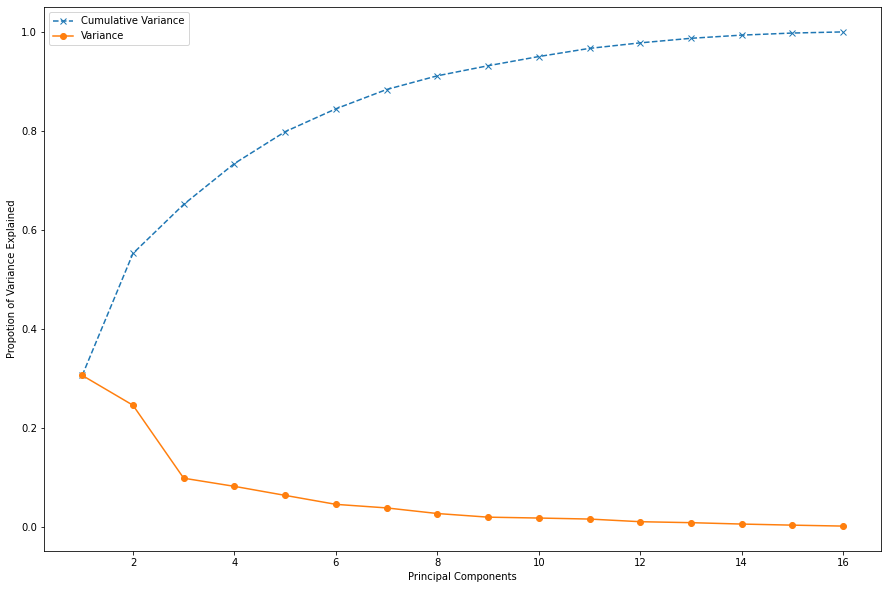

In [29]:
plt.figure(figsize =[15,10])
plt.plot(range(1, X.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), marker='x', linestyle='--',label='Cumulative Variance')
plt.plot(range(1, X.shape[1]+1), pca.explained_variance_ratio_, marker='o', label='Variance')
plt.legend()
plt.xlabel('Principal Components')
plt.ylabel('Propotion of Variance Explained')

The steepest drops are from 1 to 2 and 2 to 3. We will visualize our data using both 2 and 3 prinicipal components

### PCA Visualization in 2-D

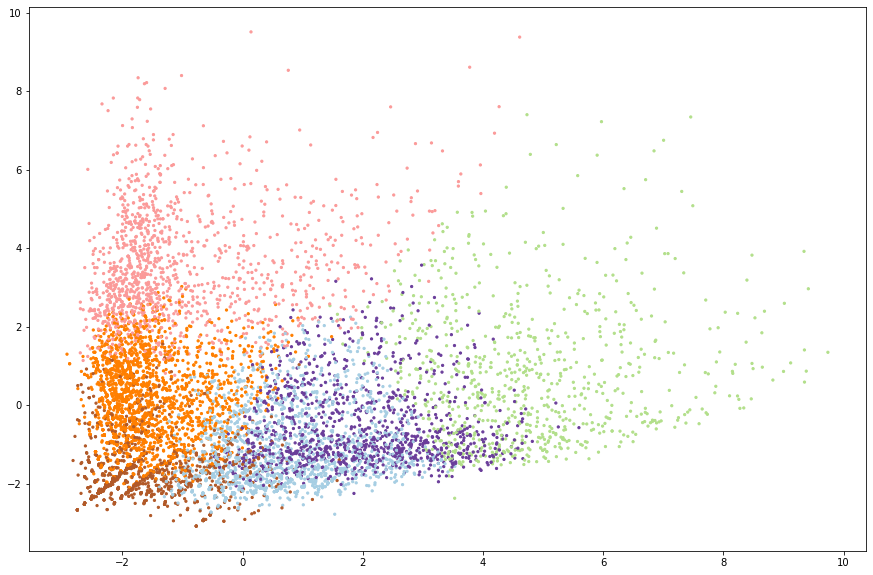

In [30]:
pca = PCA(n_components=2)
pca_transform = pca.fit_transform(X)
pc1, pc2 = zip(*pca_transform)

plt.figure(figsize=[15,10])
plt.scatter(pc1, pc2, c=cluster_labels, cmap='Paired', s=5)
plt.show()

There is still a decent amount of overlap between clusters, but less so than before binning. The clusters are also more spread out

### PCA Visualization in 3-D

In [31]:
#PCA
pca = PCA(n_components=3)
pca_transform = pca.fit_transform(X) #transformed features
pc1, pc2, pc3 = zip(*pca_transform) # unpack principal components

df_plot = pd.DataFrame({'pc1': pc1, 'pc2':pc2, 'pc3':pc3, 'cluster_labels':cluster_labels})


In [32]:
df_plot['cluster_labels'].value_counts()

3    2467
0    2053
2    1268
5    1237
4    1125
1     800
Name: cluster_labels, dtype: int64

In [33]:
# change type from numeric to category
df_plot['cluster_labels'] = df_plot['cluster_labels'].astype('category')

In [34]:
fig = px.scatter_3d(df_plot, x='pc1', y='pc2', z='pc3', color='cluster_labels', 
                    opacity=0.5,hover_name='cluster_labels', color_discrete_sequence=px.colors.qualitative.Dark2, 
                    category_orders={'cluster_labels':[i for i in np.arange(K)]},
                    title='3-D Vizualization of Principal Components',            
                   )

fig.update_traces(marker=dict(size=3.5,))

fig.show()

The clusters with binning in the 3-D graph are more distinct than the graph without binning

**PCA Visualization w/ Cosine Similarity**

In [35]:
#PCA
distance = 1 - cosine_similarity(X) #Computes pairwsie similarities bewteen all samples in X

pca = PCA(n_components=3)
pca_transform = pca.fit_transform(distance) #transformed features
pc1, pc2, pc3 = zip(*pca_transform) # unpack principal components

df_plot = pd.DataFrame({'pc1': pc1, 'pc2':pc2, 'pc3':pc3, 'cluster_labels':cluster_labels})

In [36]:
df_plot['cluster_labels'] = df_plot['cluster_labels'].astype('category')

In [37]:
fig = px.scatter_3d(df_plot, x='pc1', y='pc2', z='pc3', color='cluster_labels', 
                    opacity=0.5,hover_name='cluster_labels', color_discrete_sequence=px.colors.qualitative.Dark2, 
                    category_orders={'cluster_labels':[i for i in np.arange(K)]},
                    title='3-D Vizualization of Principal Components',            
                   )

fig.update_traces(marker=dict(size=3.5,))

fig.show()

# Profiling The clusters

Facet grid is a helpful tool to compare the distributions of the various clusters. See [here](https://seaborn.pydata.org/tutorial/axis_grids.html) for information on builidng multi plot grids. 

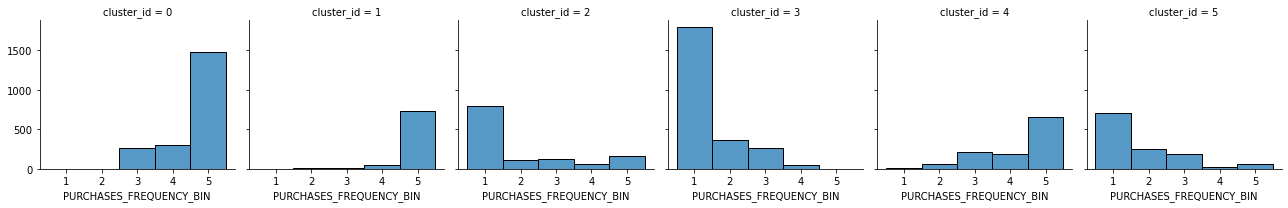

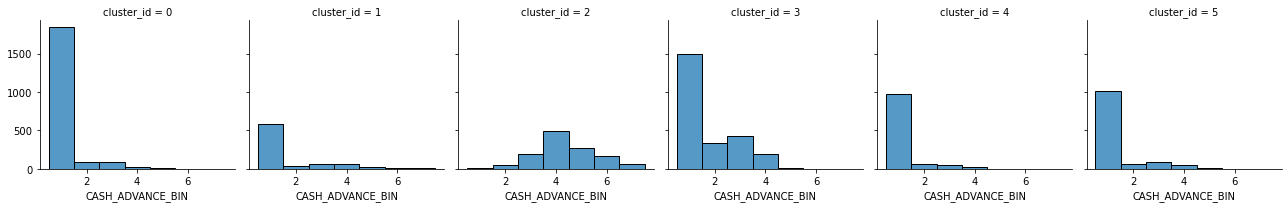

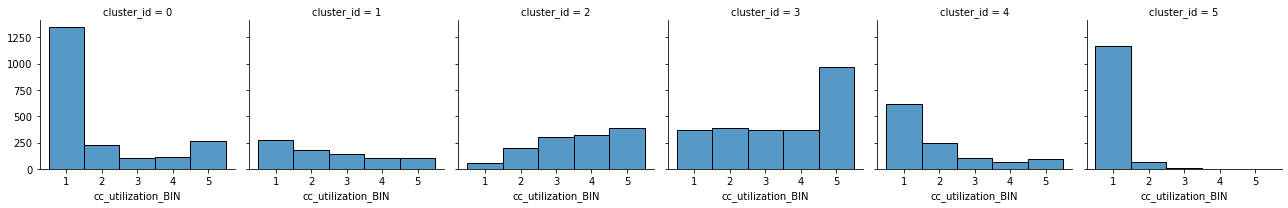

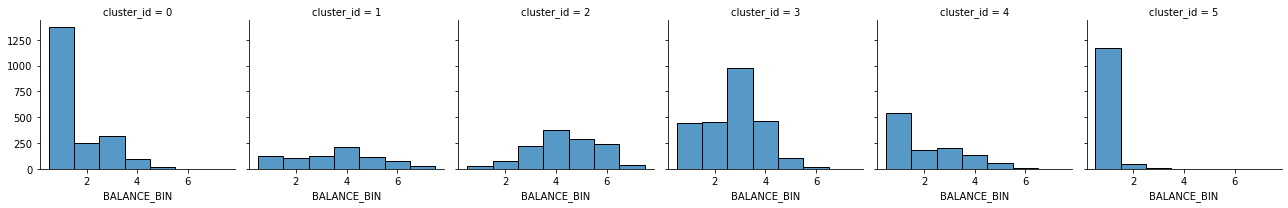

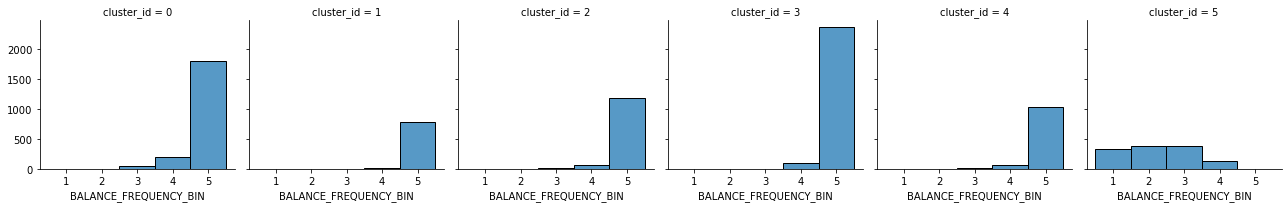

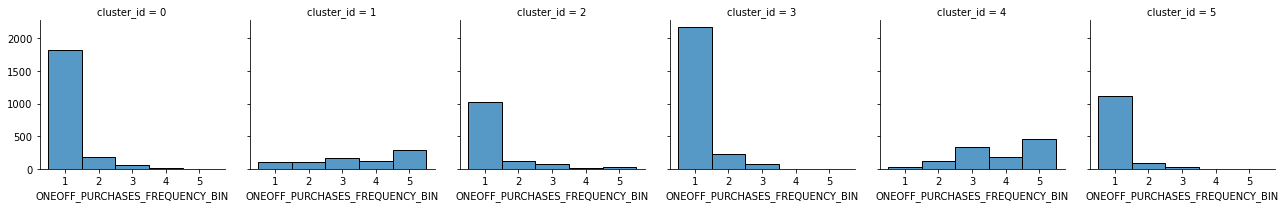

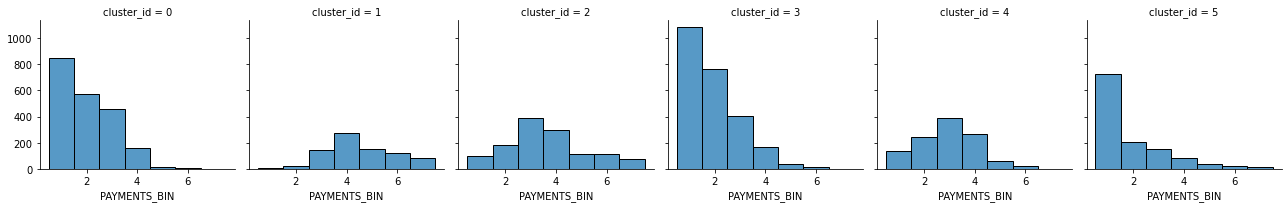

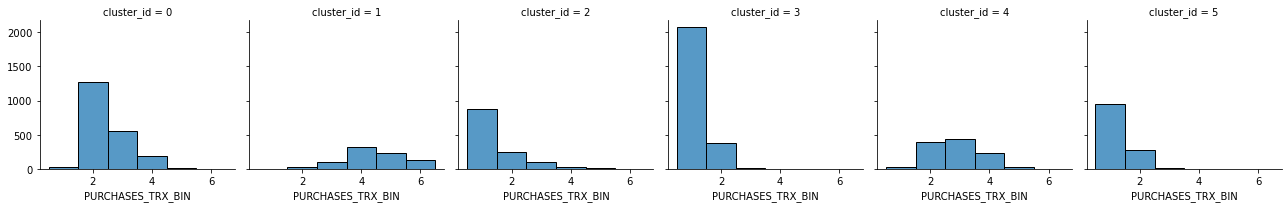

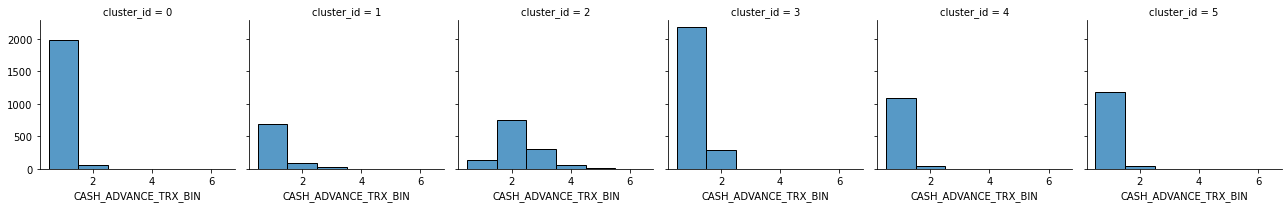

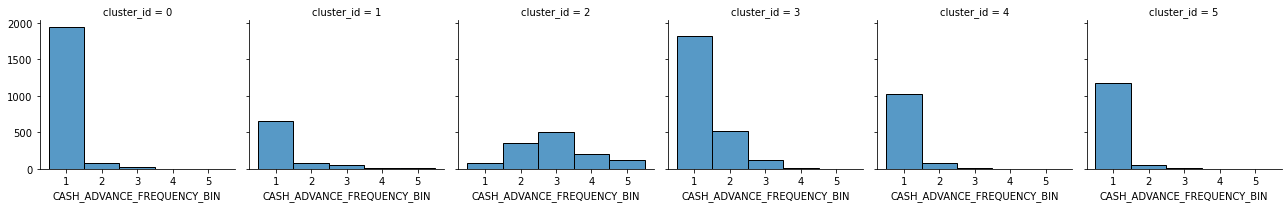

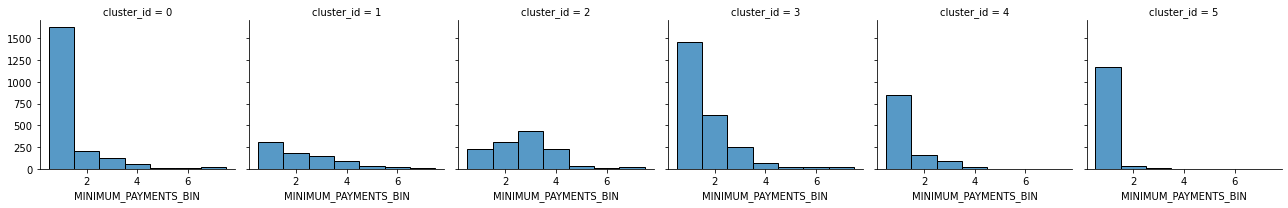

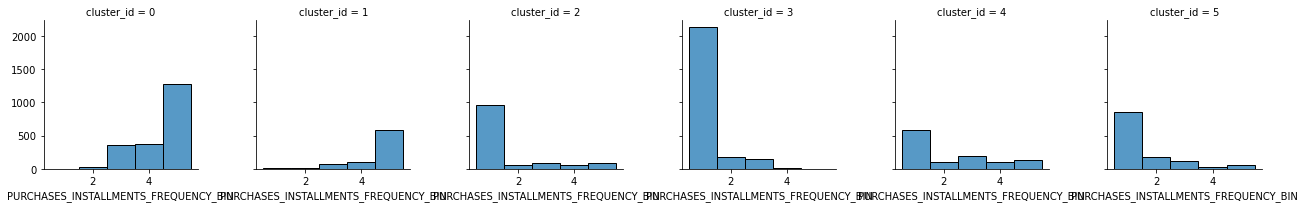

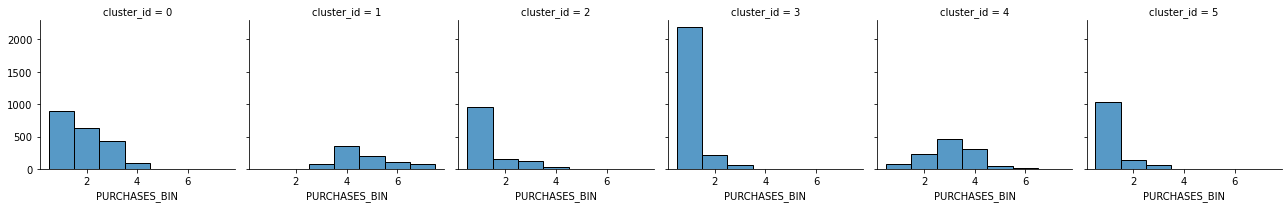

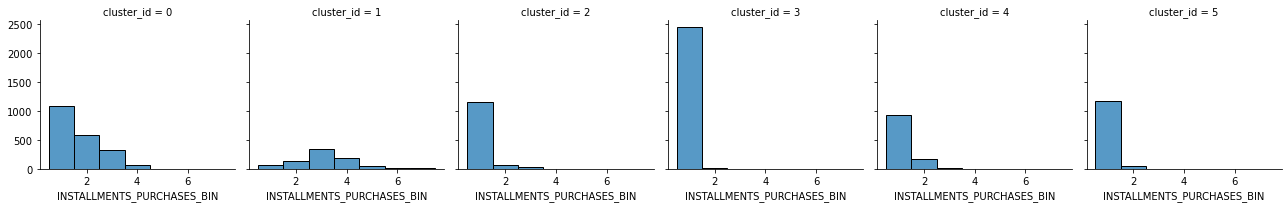

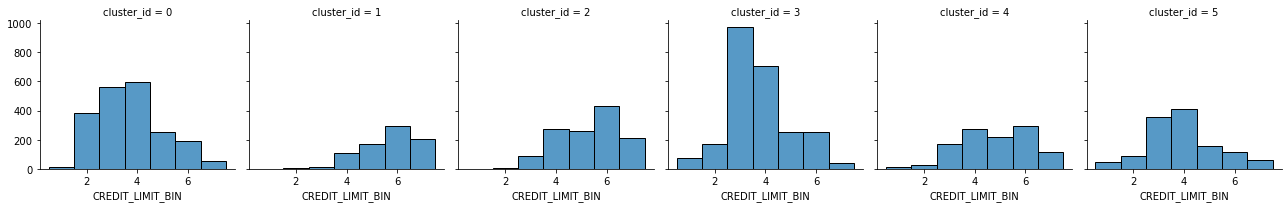

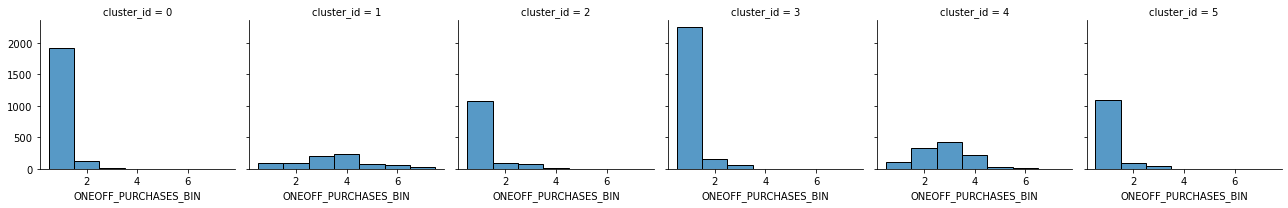

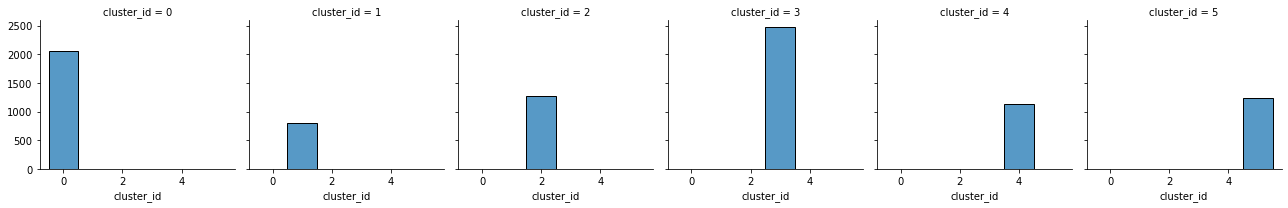

In [38]:
for feature in cc.columns:
    g =sns.FacetGrid(cc, col='cluster_id')
    g.map(sns.histplot, feature )

**Cluster 0, High Frequency Users:** The company's most frequent credit card user. Generally, they frequently use their cards for both normal purchases and purchases in installments. They make up our second largest overall user segment.

**Cluster 1, High Rollers:** The smallest cluster consisting of individuals who are willing to spend big. This segment has the highest overall average number of purchase transactions. They are people with high credit limits who frequently use their credit card and aren't afraid to maximize their credit. They are more willing to make big purchases, evident by their high purchases made in installments. For the most part, these users make their payments on time and thus the credit card utilization ratio ranges from low to high.

**Cluster 2, High Risk Users:** Individuals who are possibly at risk of defaulting. This group is also the mosting likely segment to use cash in advance as they have the highest amount of average cash advance usage, transactions, and frequency. Despite their high credit limits, these individuals have a very high balance and generally can only make minimum payments, which leads to a high credit card utilization ratio. It is worth further examining these individuals as they are possible card shutdown candidates

**Cluster 3, High Profit Users:** These users make up our biggest segments. They have an average to very high credit card utilization ratio. Here and there, they utilize cash in advance, but they keep the amount to a reasonable range. Thus, they generate revenue for the company through high interests associated with cash in advance but are less risky and less extreme than cluster 2.

**Cluster 4, The Average User:** Average to high frequency credit card users who make an average number of purchase transactions. They prefer to make one-off purchases and do so quite frequently.

**Cluster 5, Credit Conscious Consumers:** Low risk users who are extremely mindful of their credit. They carry an exceptionally low balance and thus a very low credit card utilization ratio